In [4]:
!pip install pyathena

  Using cached pyathena-3.5.1-py3-none-any.whl.metadata (5.5 kB)
  Using cached urllib3-1.26.18-py2.py3-none-any.whl.metadata (48 kB)
Using cached pyathena-3.5.1-py3-none-any.whl (69 kB)
Using cached urllib3-1.26.18-py2.py3-none-any.whl (143 kB)
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.1.0
    Uninstalling urllib3-2.1.0:
      Successfully uninstalled urllib3-2.1.0

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [24]:
import os
import boto3
import sagemaker
import pandas as pd
import numpy as np
import csv, json
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display, Image as IImage
from io import StringIO
from pyathena import connect
import warnings
warnings.filterwarnings('ignore')

In [6]:
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
region = boto3.Session().region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [7]:
# Initialize Boto3 Rekognition client

rekognition_client = boto3.client("rekognition")
s3 = boto3.client("s3")

# Detect labels in Traffic sign images

In [8]:
# Define s3 bucket name, prefix and output csv file path

bucket_name = 'finalprojectdata'
prefix_key = 'traffic_signs/'
output_csv_key = 'csv_files/traffic_signs.csv'

In [9]:
# Function to detect text from an image 

def detect_text_from_image(bucket_name, image_key):
    if image_key.endswith('.jpg'):
        rekognition_response = rekognition_client.detect_text(Image={'S3Object': {'Bucket': bucket_name, 'Name': image_key}})
        return rekognition_response

In [10]:
# Get a list of objects in the s3 bucket

# all_results = []

# paginator = s3.get_paginator('list_objects_v2')
# result = paginator.paginate(Bucket=bucket_name, Prefix=prefix_key)

# for page in result:
#     if "Contents" in page:
#         for key in page[ "Contents" ]:
#             keyString = key[ "Key" ]
#             print(keyString)
#             if keyString.endswith('.jpg'):
#                 response = detect_text_from_image(bucket_name, keyString)
#                 all_results.append({'Image': keyString, 'TextDetections': response['TextDetections']})

In [61]:
# Write aggregated results to a single CSV file

csv_buffer = StringIO()
writer = csv.DictWriter(csv_buffer, fieldnames=['Image', 'DetectedText', 'Type', 'Confidence'])
writer.writeheader()
for result in all_results:
    image_key = result['Image']
    for detection in result['TextDetections']:
        detected_text = detection['DetectedText']
        text_type = detection['Type']
        confidence = detection['Confidence']
        writer.writerow({'Image': image_key, 'DetectedText': detected_text, 'Type': text_type, 'Confidence': confidence})
        
# Upload CSV string to S3

csv_buffer.seek(0)
s3.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=output_csv_key)

print(f"Text detection results saved to: s3://{bucket_name}/{output_csv_key}")

Text detection results saved to: s3://finalprojectdata/csv_files/traffic_signs.csv


In [11]:
# Create athena database

sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
region = boto3.Session().region_name

ingest_create_athena_db_passed = False

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [12]:
# Set Athena database name

database_name = "velocityvision"

In [13]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries

s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [14]:
# Connect to s3 using PyAthena

conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [15]:
# SQL statement to execute

statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS velocityvision


""


In [66]:
input_data_location = "s3://finalprojectdata/csv_files"

In [68]:
# SQL statement to execute the traffic signs text detection

table_name1 = 'traffic_signs'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name1}', conn)

create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name1}(
            image_id string,
            detected_text string,
            type string,
            confidence float
            )
            
            ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
            LOCATION '{input_data_location}'
            TBLPROPERTIES ('skip.header.line.count'='1')
"""

pd.read_sql(create_table, conn)

pd.read_sql(f'SELECT * FROM {database_name}.{table_name} LIMIT 5', conn)

,image_id,detected_text,type,confidence
0,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,30,LINE,99.548250
1,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,RYARSH,LINE,99.415030
2,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,Please reduce,LINE,99.164894
3,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,your speed,LINE,99.207320
4,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,30,WORD,99.548250


In [19]:
# SQL statement to execute the analysis of vehicle speed

table_name2 = 'vehicle_speed'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name2}', conn)

create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name2}(
             latitude float,
             longitude float,
             target_speed float,
             way_maxspeed float,
             speed_osrm float,
             elevation float,
             fwd_azimuth float,
             way_type string,
             way_surface string,
             node_intersection string,
             node_railway string,
             node_crossing string,
             node_highway string,
             node_stop string,
             start_stop int,
             azimuth_diff int,
             elevation_diff float
             )
             
             ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
             LOCATION 's3://finalprojectdata/vehicle_speed'
             TBLPROPERTIES ('skip.header.line.count'='1')
"""

pd.read_sql(create_table, conn)

""


In [20]:
vehicle_speed_df = pd.read_sql(f'SELECT * FROM {database_name}.{table_name2}', conn)
vehicle_speed_df.head()

,latitude,longitude,target_speed,way_maxspeed,speed_osrm,elevation,fwd_azimuth,way_type,way_surface,node_intersection,node_railway,node_crossing,node_highway,node_stop,start_stop,azimuth_diff,elevation_diff
0,50.397060,14.913273,39.739456,130.0,28.837246,229.77516,46.24135,motorway,asphalt,None,None,None,None,None,0,0.0,-0.025587
1,50.397068,14.913283,39.717785,130.0,28.875628,229.74959,46.24135,motorway,asphalt,None,None,None,None,None,0,0.0,-0.025587
2,50.397076,14.913294,39.696114,130.0,28.914007,229.72400,46.24135,motorway,asphalt,None,None,None,None,None,0,0.0,-0.025587
3,50.397080,14.913303,39.674442,130.0,28.952387,229.69841,46.24135,motorway,asphalt,None,None,None,None,None,0,0.0,-0.025587
4,50.397087,14.913314,39.652770,130.0,28.990767,229.67282,46.24135,motorway,asphalt,None,None,None,None,None,0,0.0,-0.025587


# Exploratory Data Analysis

Text(0, 0.5, 'Count')

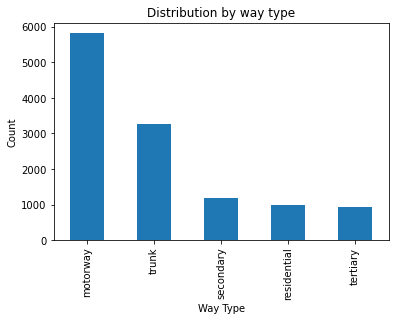

In [25]:
# Distrubition by Way type

vehicle_speed_df['way_type'].value_counts().plot(kind="bar", title="Distribution by way type")
plt.xlabel("Way Type")
plt.ylabel("Count")

# 2. Data Preprocessing

## 2.1. Handling Missing Values

In [21]:
vehicle_speed_df.isnull().sum()

latitude                 0
longitude                0
target_speed             0
way_maxspeed             0
speed_osrm               0
elevation                0
fwd_azimuth              0
way_type                 0
way_surface              0
node_intersection    12165
node_railway         12165
node_crossing        12165
node_highway         12165
node_stop            12165
start_stop               0
azimuth_diff             7
elevation_diff           0
dtype: int64

From the above output, it is observed that 5 columns have 80% null values and hence dropping them.

In [26]:
# Dropping columns that have null values

vehicle_speed_df = vehicle_speed_df.drop(['node_intersection', 'node_railway', 'node_crossing', 'node_highway', 'node_stop'], axis=1)

,latitude,longitude,target_speed,way_maxspeed,speed_osrm,elevation,fwd_azimuth,way_type,way_surface,start_stop,azimuth_diff,elevation_diff
0,50.397060,14.913273,39.739456,130.0,28.837246,229.77516,46.24135,motorway,asphalt,0,0.0,-0.025587
1,50.397068,14.913283,39.717785,130.0,28.875628,229.74959,46.24135,motorway,asphalt,0,0.0,-0.025587
2,50.397076,14.913294,39.696114,130.0,28.914007,229.72400,46.24135,motorway,asphalt,0,0.0,-0.025587
3,50.397080,14.913303,39.674442,130.0,28.952387,229.69841,46.24135,motorway,asphalt,0,0.0,-0.025587
4,50.397087,14.913314,39.652770,130.0,28.990767,229.67282,46.24135,motorway,asphalt,0,0.0,-0.025587
